# "Performance Space Analysis" clustermaps of whole population DAGs in GP

This notebook builds a short ManimCE animation showing a collection of numerical GP trees (of fixed size) drawn from a specified function language. Everything should run in a Jupyter notebook, as far as I'm aware. Most of the GP-related and tree-manipulating stuff is called from the `pushTrees.py` module.

Because ManimCE doesn't (yet) allow direct manipulation of `matplotlib` and `seaborn` plots, I first save still images generated through `seaborn`, and then re-load those into Manim `ImageMobject` holders to show them in the movie.

**Note** every time the animation is run, it re-generates the random trees and runs the entire plotting method, so if you want to save your data, move the movie or still files aside before they get overwritten.

### target functions

There's no evolutionary search here, but the numerical values used in the clustermap generation are actual training cases from one of three symbolic regression problems I've thrown in:

- Kotanchek's 2-d "bump"
- Salutowicz's trig monster
- Vladislavleva's UBall 5d example

There's nothing in particular special about these (though they are considered complicated enough to be interesting), but none of them has more than 5 inputs or 5 required constants. That's an implicit limit in the functions I've included here.

The representation scheme is arbitrary but a bit fragile. The tokens and their arities are specified in the `littleLanguage` dictionary, and the numerical definitions used to populate the clustermap data table are in `littleLanguageLambdas`. This is not robust to functions that produce `Infty` or `NaN` results, so you'll notice `exp()` is not present. That's fixable, but `¯\_(ツ)_/¯`.

The process of building a the performance space clustermap is:

- construct the DAG for the accumulated population
- collect the keys of the DAG (the functions proper), and sort them
- iterating over several training cases, gather values for every node of the DAG, given the training case's assigned `x` and `k` leaf values
- add a tiny tiny amount of noise (to make the correlation work without complaining about constant functions)
- plot with `seaborn`


In [2]:
# for reading and writing plot files in the local directory
import sys
sys.path.append('..')

from pushTrees import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import scipy as sci
import math

In [3]:
# copying without too much attention from 
# https://darioizzo.github.io/dcgp/docs/python/vladislavleva_problems.html

def kotanchek(x1,x2):
    return math.exp(-1 * (x1 - 1)**2) / (1.2 + (x2 - 2.5)**2)

def kotanchekCase():
    x1 = np.random.uniform(0.3,4)
    x2 = np.random.uniform(0.3,4)
    x3 = np.random.uniform(0.3,4)
    x4 = np.random.uniform(0.3,4)
    x5 = np.random.uniform(0.3,4)
    return {":x1":x1, ":x2":x2, ":x3":x3, ":x4":x4, ":x5":x5, "y": kotanchek(x1,x2)}

def salutowicz(x1):
    c = math.cos(x1)
    s = math.sin(x1)
    return math.exp(-x1) * x1**3 * c * s * (c * s * s - 1)

def salutowiczCase():
    x1 = np.random.uniform(0.5,10)
    x2 = np.random.uniform(0.5,10)
    x3 = np.random.uniform(0.5,10)
    x4 = np.random.uniform(0.5,10)
    x5 = np.random.uniform(0.5,10)
    return {":x1":x1, ":x2":x2, ":x3":x3, ":x4":x4, ":x5":x5, "y": salutowicz(x1)}

def uBall5d(x1,x2,x3,x4,x5):
    denom = (x1-3.0)**3 + (x2-3.0)**2 + (x3-3.0)**2 + (x4-3.0)**2 + (x5-3.0)**2 + 5
    return 10.0 / denom

def uBall5dCase():
    x1 = np.random.uniform(0.05,6.05)
    x2 = np.random.uniform(0.05,6.05)
    x3 = np.random.uniform(0.05,6.05)
    x4 = np.random.uniform(0.05,6.05)
    x5 = np.random.uniform(0.05,6.05)
    return {":x1":x1, ":x2":x2, ":x3":x3, ":x4":x4, ":x5":x5, "y": uBall5d(x1,x2,x3,x4,x5)}

Manim Community v0.18.1

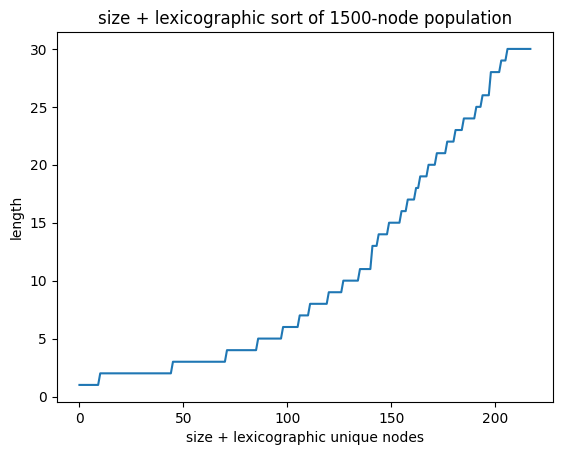

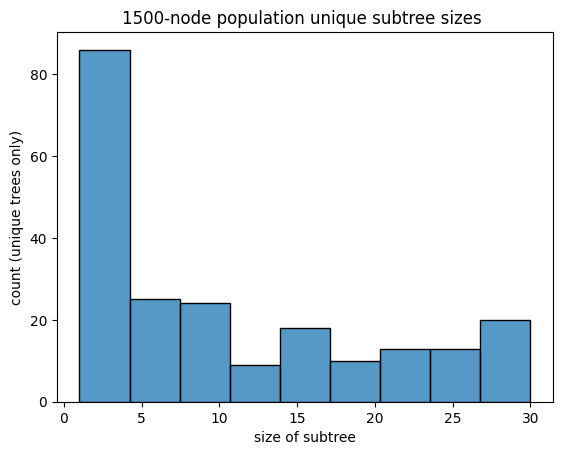

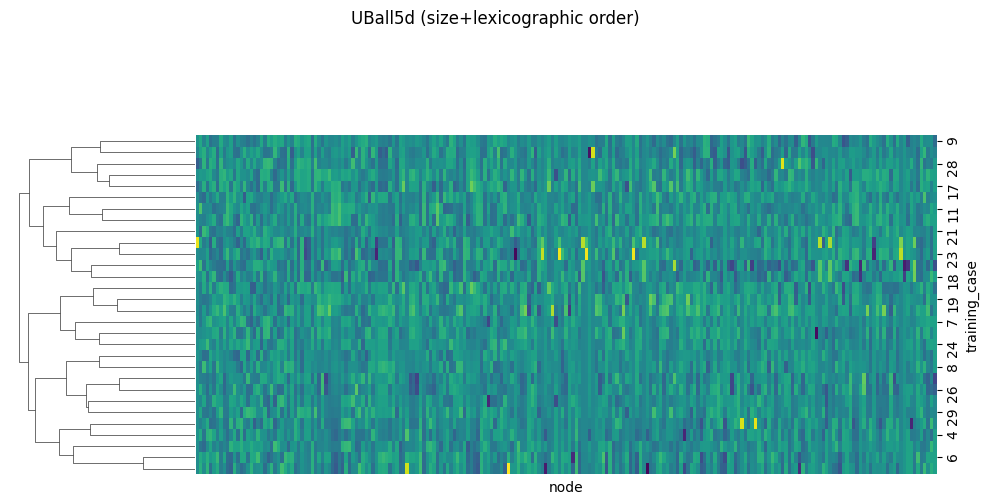

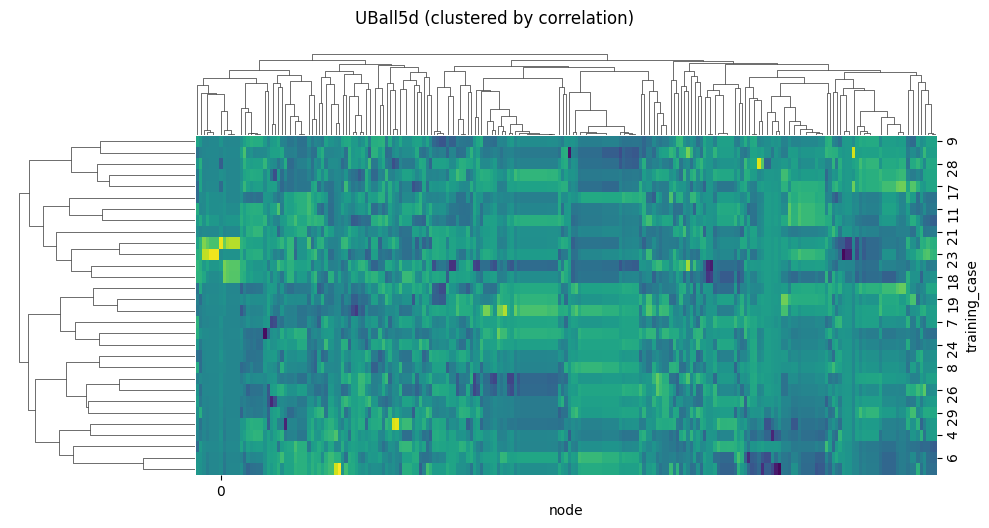

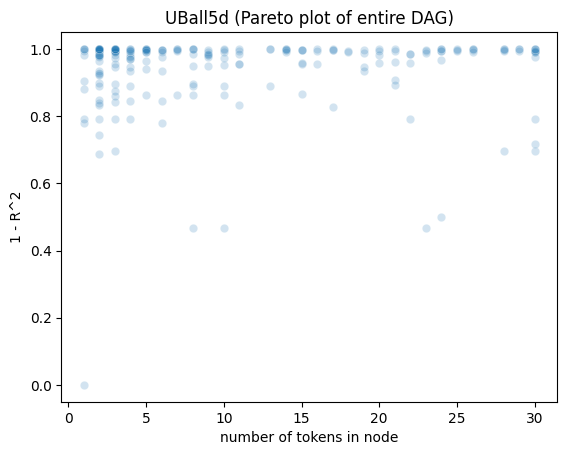

In [6]:
%%manim -qm -v WARNING PerformanceSpaceWholePop
## this is the ManimCE "magic line", which invokes Manim on the class below when it's invoked; 
# note the `-qm` arg sets medium quality, for faster rendering




class PerformanceSpaceWholePop(MovingCameraScene): 
    def construct(self):

        ## settings to fiddle
        littleLanguage = {":x1":0,":x2":0,":x3":0,":x4":0,":x5":0,":k1":0,":k2":0,":k3":0,
                 ":k4":0,":k5":0,":abs":1,":cos":1,":sin":1,":psqrt":1,":squared":1,":plog":1,":add":2,
                ":mul":2,":sub":2,":pdiv":2,":ifLTZ":3}
        inputs = [':x1',':x2',':x3',':x4',':x5'] 
        constants = [':k1',':k2',':k3',':k4',':k5']
        treeSize = 30 # absolute number of nodes
        numberOfTrees = 11 # this is how many to gather, after the first (which needs to exist)
                           # max=29, because the grid of diagrams is 6 columns x 5 rows
        numberOfTrainingCases = 30 # should be way more than 1

        ## internal components
        chartData = [0]
        memory = {} ## the memory dict---used for every tree created

        ## video setup
        trees=VGroup(*[Square(side_length=1) for s in range(30)]).arrange_in_grid(cols=6,buff=0.1).fade(0.8).move_to(3.5*LEFT+UP)
        self.play(Create(trees))


        ## producing the first tree separately to initialize some settings as side-effects
        
        # the fixedTreeSize() function returns a list containing the tree (for no good reason)
        # the nodes are named using token names, appended by `@` and a unique number
        # because NetworkX wants unique node names, below
        randomTree = fixedTreeSize(treeSize,littleLanguage)[0]
        
        # sideEffecter here is literally being run to add the DAG to the `memory` dict
        sideEffecter = streamToTreeBuilder(flatPush(randomTree),littleLanguage,'postfix','standard',memory)
        
        # makeTree() produces a NetworkX graph from a list of tokens
        thisSubtree = makeTree(randomTree,None,None,'postfix')
        
        # ManimCE Graph mobject built from parts from a NetworkX graph
        stackTree = Graph(
            thisSubtree.nodes,
            thisSubtree.edges, 
            layout='tree', root_vertex=list(thisSubtree)[0])
        stackTree.set_color(ORANGE)
        
        # draw this graph in the grid
        self.add(stackTree.scale(trees[0].width/max(stackTree.width,stackTree.height)).move_to(trees[0].get_center()))
    
        # add numberOfTrees more, accumulating the memory as you go
        for i in range(numberOfTrees):
            randomTree = fixedTreeSize(treeSize,littleLanguage)[0]
            sideEffecter = streamToTreeBuilder(flatPush(randomTree),littleLanguage,'postfix','standard',memory)
            thisSubtree = makeTree(randomTree,None,None,'postfix')
            stackTree = Graph(
                thisSubtree.nodes,
                thisSubtree.edges, 
                layout='tree', root_vertex=list(thisSubtree)[0])
            stackTree.set_color(ORANGE)
            
            self.play(Create(stackTree.scale(trees[i+1].width/max(stackTree.width,stackTree.height)).move_to(trees[i+1].get_center())),run_time=0.1)

        # captioning video
        self.wait(5)
        sideCaption = MarkupText("Look at the work\nwe&#8217;ve done:", font="Didot", slant=ITALIC, font_size=32).scale_to_fit_width(6).move_to(RIGHT*3.5)
        self.play(Create(sideCaption))
        self.wait(3)
        self.play(*[FadeOut(mob) for mob in self.mobjects])

        # gather a collection of ever function encountered so far
        sortedFunctions =  sorted(sorted(list(memory.keys())),key=lambda x:len(x.split()))

        # count the number of tokens in every function
        yData = list(map(lambda x: (len(x.split())), sortedFunctions))

        # plot cumulative line plot of sorted function lengths
        popSizeCurve = sns.lineplot(yData)
        plt.title("size + lexicographic sort of 1500-node population")
        popSizeCurve.set(xlabel='size + lexicographic unique nodes', ylabel='length')
        popSizeCurve.figure.savefig("popCurveChart.png")
        plt.show()

        # same data, as a histogram of function sizes
        subtreeHistogram = sns.histplot(yData)
        plt.title("1500-node population unique subtree sizes ")
        plt.xlabel("size of subtree")
        plt.ylabel("count (unique trees only)")
        plt.savefig("subtreeHistogram.png", dpi=600, format='png')
        plt.show()


        ## set up clustermap data
        
        # we're going to evaluate every function, based on the text token as it appears 
        # in the memory postfix functions

        # some of those need to be defined
        # like "protected log":
        def plog(x):
            if x<0.0:
                return np.log(abs(x))
            elif x>0.0:
                return np.log(x)
            else:
                return 1.0

        def generateDAGvalues(assignments,functions,dictMem):
            sortedSubtrees =  sorted(sorted(list(dictMem.keys())),key=lambda x:len(x.split()))
            dagValues = {}
            for k in sortedSubtrees:
                if k in assignments.keys():
                    dagValues[k] = assignments[k]
                else: # calculate it
                    tuple = dictMem[k]
                    actor = tuple[-1]
                    args = []
                    for a in tuple[0:-1]:
                        args.append(dagValues[a])
                    dagValues[k] = functions[actor](*args)
            return dagValues

        # the constants are assigned outside the loop; 
        # this would allow them to be simultaneously improved for the 
        # entire DAG at once (a process not shown here)
        constants = {":k1": np.random.uniform(-10,10),
                ":k2": np.random.uniform(-10,10),
                ":k3": np.random.uniform(-10,10),
                ":k4": np.random.uniform(-10,10),
                ":k5": np.random.uniform(-10,10)}
        
        dataCollector = []

        # this does the work of propagating the calculations in small-to-big order

        # number of training cases is hard-coded for no reason
        for tc in range(numberOfTrainingCases):
            
            # sample a new random case
            trainingCase = uBall5dCase() # change to one of the others if you like
            trainingAssignments = {":x1": trainingCase[":x1"],
                ":x2": trainingCase[":x2"],
                ":x3": trainingCase[":x3"],
                ":x4": trainingCase[":x4"],
                ":x5": trainingCase[":x5"],
                ":k1": constants[":k1"],
                ":k2": constants[":k2"],
                ":k3": constants[":k3"],
                ":k4": constants[":k4"],
                ":k5": constants[":k5"],
                }

            ## function to be applied to input values, by token
            littleLanguageLambdas = {
                ":x1":       lambda: trainingAssignments[":x1"],
                ":x2":       lambda: trainingAssignments[":x2"],
                ":x3":       lambda: trainingAssignments[":x3"],
                ":x4":       lambda: trainingAssignments[":x4"],
                ":x5":       lambda: trainingAssignments[":x5"],
                ":k1":       lambda: trainingAssignments[":k1"],
                ":k2":       lambda: trainingAssignments[":k2"],
                ":k3":       lambda: trainingAssignments[":k3"],
                ":k4":       lambda: trainingAssignments[":k4"],
                ":k5":       lambda: trainingAssignments[":k5"],
                ":abs":      lambda a1: abs(a1),
                ":cos":      lambda a1: math.cos(a1),
                ":sin":      lambda a1: math.sin(a1),
                ":psqrt":    lambda a1: np.sqrt(abs(a1)),
                ":squared":  lambda a1: a1*a1,
                ":plog":     lambda a1: plog(a1),
                ":add":      lambda a1,a2: a1 + a2,
                ":mul":      lambda a1,a2: a1 * a2,
                ":sub":      lambda a1,a2: a1 + a2,
                ":pdiv":     lambda a1,a2: (a1 / a2) if a2 != 0.0 else 0.0,
                ":ifLTZ":    lambda a1,a2,a3: a2 if a1<0.0 else a3,
                }

            # propagate values
            myAssignments = generateDAGvalues(trainingAssignments,littleLanguageLambdas,memory)
            
            # add the target value of this training case as element 0 of the list
            dataCollector.append([0, tc, 0, trainingCase["y"]])
            
            # for each cell, do the math, and add a little noise
            keyNumber = 1
            for k in myAssignments:
                dataCollector.append([keyNumber, tc, len(k.split()), myAssignments[k] + np.random.uniform(-0.0000001,0.0000001)])
                keyNumber += 1

        
        # munge the array into something seaborn will like
        clusterData = pd.DataFrame(dataCollector, columns = ['node', 'training_case', 'length', 'value'])
        # pivot the data
        wideData = clusterData.pivot(index='training_case', columns='node', values='value')

        # build the unrearranged clustermap
        cluster0 = sns.clustermap(wideData,  metric="correlation", method='average', 
                        cmap='viridis', z_score=1, center=0, figsize=(10,5), 
                        xticklabels=False, col_cluster=False, row_cluster=True, cbar_pos=None)
        plt.subplots_adjust(top=0.9, bottom=0.05)
        plt.suptitle("UBall5d (size+lexicographic order)")
        cluster0.figure.savefig("noClusterMap.png")
        plt.show() # to see it in the notebook results


        # build the column-clustered clustermap, using correlation
        cluster1 = sns.clustermap(wideData,  metric="correlation", method='average', 
                                cmap='viridis', z_score=1, center=0, figsize=(10,5), 
                                xticklabels=False, row_cluster=True,  cbar_pos=None)
        
        # fiddling so that only the target value column ("0") is shown in the axis label
        reordered_labels = clusterData.index[cluster1.dendrogram_col.reordered_ind].tolist()
        use_labels = [0]
        use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
        cluster1.ax_heatmap.set(xticks=use_ticks, xticklabels=use_labels)
        plt.subplots_adjust(top=0.9, bottom=0.05)
        plt.suptitle("UBall5d (clustered by correlation)")
        cluster1.figure.savefig("clusterMap.png")
        plt.show()


        ## Pareto-GP chart
        
        # various gyrations to get `numpy` to produce pairwise correlations between columns/functions
        allCorrelations = {}
        pivoted = pd.DataFrame.to_numpy(wideData)
        targets = pivoted[:,[0]].flatten()
        cols = np.shape(pivoted)[1]
        paretoData =[]
        # print(np.shape(pivoted)) debugging

        # building the dataset for plotting 1-R^2 vs length
        for c in range(len(myAssignments)-1):
            observed = pivoted[:,[c]].flatten()
            code = list(myAssignments.keys())[c]
            paretoData.append([ 1.0 - sci.stats.pearsonr(targets,observed).statistic**2, len(code.split())])
        
        # seaborn plot
        paretoPlotFrame = pd.DataFrame(paretoData, columns = ['correlation', 'length'])
        paretoPlot = sns.scatterplot(paretoPlotFrame, x='length', y='correlation', alpha = 0.2)
        paretoPlot.set(xlabel='number of tokens in node', ylabel='1 - R^2')
        plt.title("UBall5d (Pareto plot of entire DAG)")
        paretoPlot.figure.savefig("paretoPlot.png")
        plt.show() # to see in notebook


        ## back to the movie, now that the pieces are built and saved
        self.wait(1)
        plot1 = ImageMobject("popCurveChart.png").scale_to_fit_height(6)
        plot1b = ImageMobject("subtreeHistogram.png").scale_to_fit_height(6)
        plot2 = ImageMobject("noClusterMap.png").scale_to_fit_height(6)
        plot3 = ImageMobject("clusterMap.png").scale_to_fit_height(6)
        plot4 = ImageMobject("paretoPlot.png").scale_to_fit_height(6)


        self.play(FadeIn(plot1))
        self.wait(5)

        self.play(FadeOut(plot1), FadeIn(plot1b))
        self.wait(5)

        self.play(FadeOut(plot1b), FadeIn(plot2))
        self.wait(5)

        self.play(FadeOut(plot2), FadeIn(plot3))
        self.wait(5)

        self.play(FadeOut(plot3), FadeIn(plot4))
        self.wait(5)


        # fade out
        self.wait(5)
        self.play(*[FadeOut(mob) for mob in self.mobjects])
        self.wait(1)